In [1]:
!pip install --upgrade mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import math
import random
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error
import yfinance as yf

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
# Downloading stock data for Apple (AAPL) from Yahoo Finance
stock_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')
specific_df = pd.DataFrame(stock_data).reset_index()
specific_df['Name'] = 'AAPL'
print(specific_df.head())

[*********************100%%**********************]  1 of 1 completed

        Date       Open       High        Low      Close  Adj Close  \
0 2020-01-02  74.059998  75.150002  73.797501  75.087502  73.059425   
1 2020-01-03  74.287498  75.144997  74.125000  74.357498  72.349129   
2 2020-01-06  73.447502  74.989998  73.187500  74.949997  72.925636   
3 2020-01-07  74.959999  75.224998  74.370003  74.597504  72.582657   
4 2020-01-08  74.290001  76.110001  74.290001  75.797501  73.750244   

      Volume  Name  
0  135480400  AAPL  
1  146322800  AAPL  
2  118387200  AAPL  
3  108872000  AAPL  
4  132079200  AAPL  


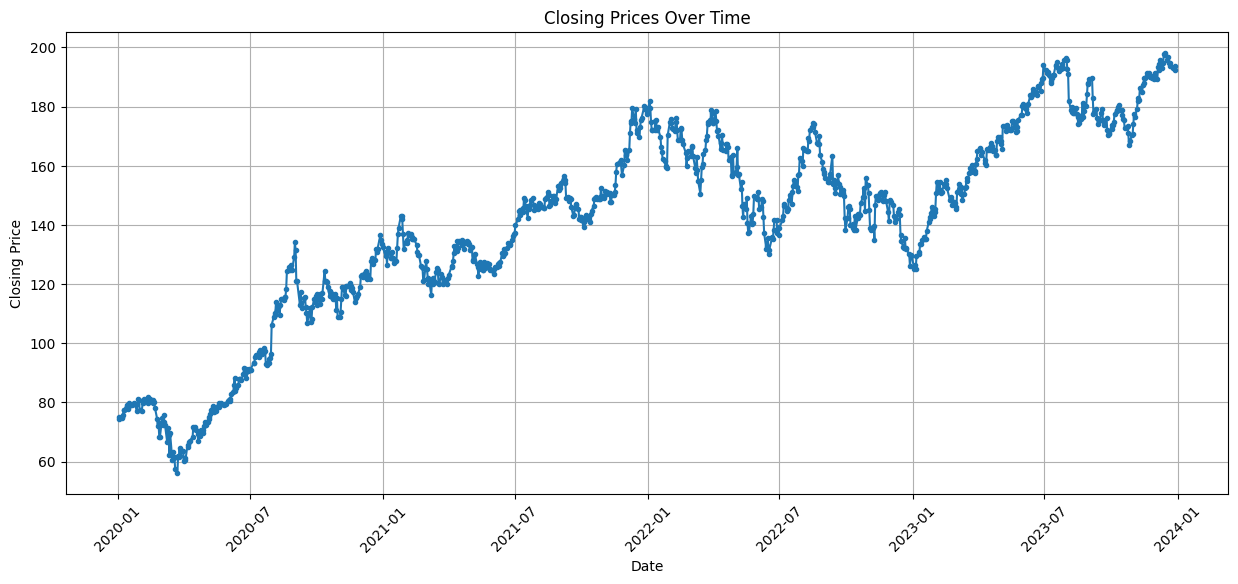

In [4]:
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

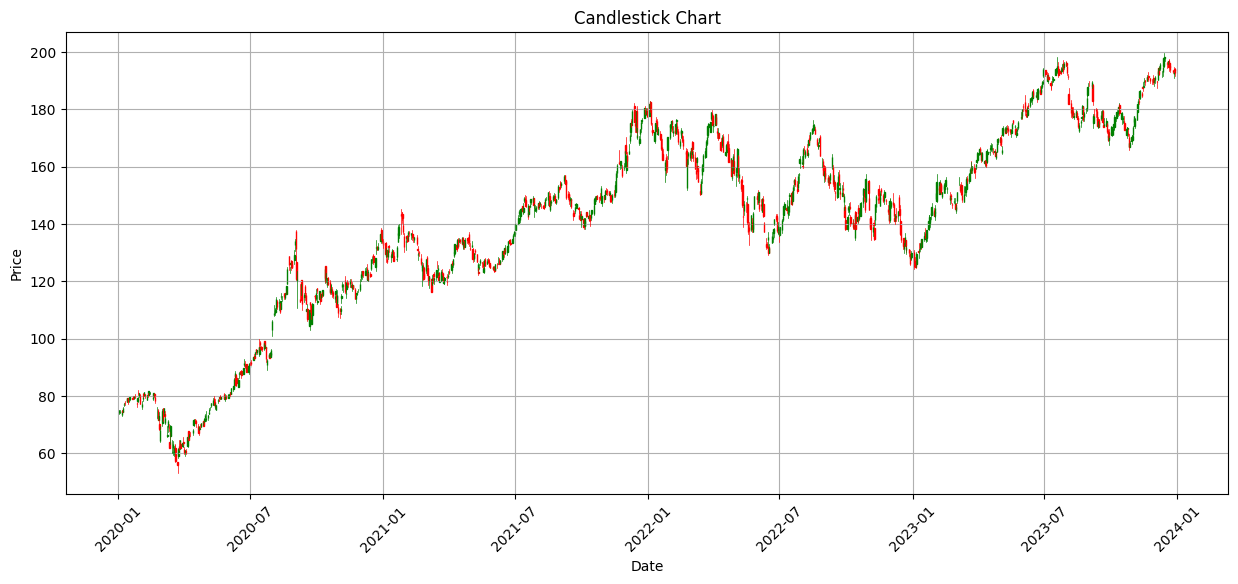

In [5]:
matplotlib_date = mdates.date2num(specific_df['Date'])
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T
plt.figure(figsize=(15,6))
ax=plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

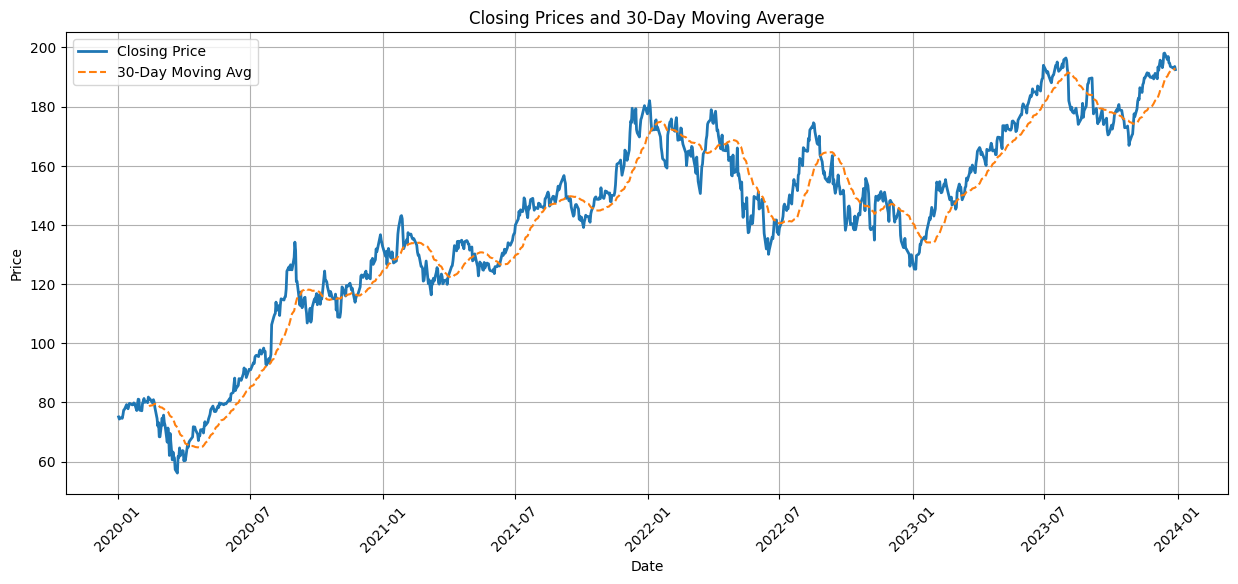

In [6]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

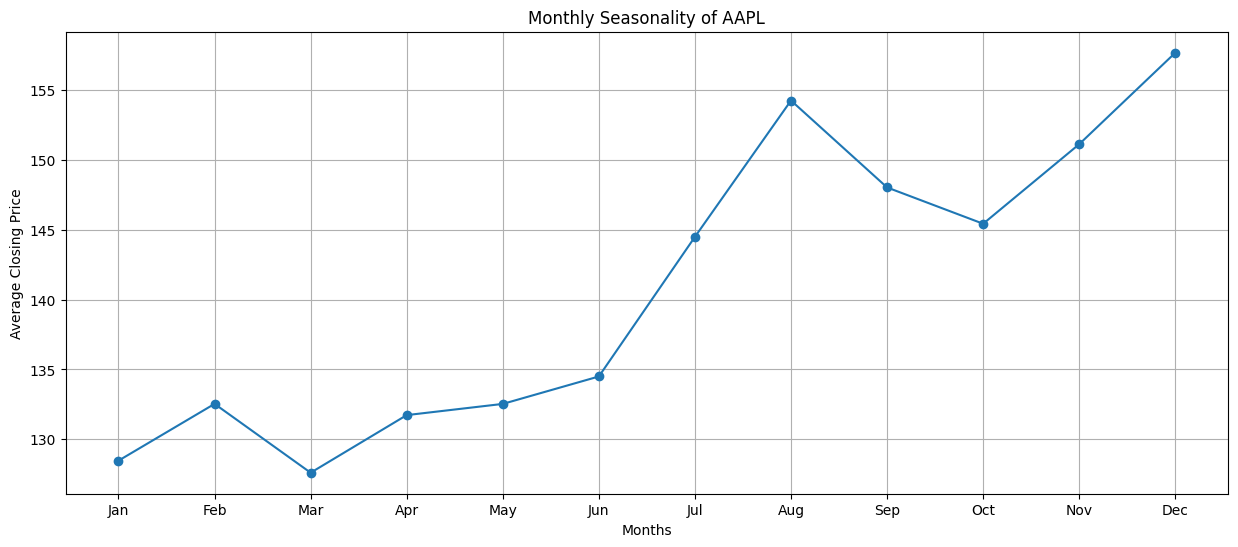

In [7]:
company_name = 'AAPL'
specific_df['Month'] = specific_df['Date'].dt.month
monthly_average = specific_df.groupby('Month')['Close'].mean()

plt.figure(figsize=(15,6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [8]:
new_df = specific_df.reset_index()['Close']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [9]:
from sklearn.model_selection import train_test_split
test_size = 0.2
train_data, test_data = train_test_split(scaled_data, test_size=test_size, shuffle=False)

In [10]:
def generate_sequences_and_labels(data, n_past):
    sequences = [data[i - n_past:i, 0] for i in range(n_past, len(data))]
    labels = [data[i, 0] for i in range(n_past, len(data))]
    return np.array(sequences), np.array(labels)

In [11]:
n_past = 60
x_train, y_train = generate_sequences_and_labels(train_data, n_past)
x_test, y_test = generate_sequences_and_labels(test_data, n_past)

In [12]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [13]:
def build_lstm_model(input_shape, units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=[input_shape, 1]))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    return model

In [14]:
def compile_lstm_model(model):
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model

In [15]:
def train_lstm_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=300, batch_size=32, verbose=1)
    return model

In [16]:
# Define parameters for k-fold cross-validation and grid search
from sklearn.model_selection import KFold, GridSearchCV
param_grid = {
    'units': [50, 100],  # LSTM units
    'dropout_rate': [0.2, 0.3]  # Dropout rate
}
kf = KFold(n_splits=5, shuffle=True)

In [17]:
# Perform k-fold cross-validation and grid search
best_model = None
best_score = float('inf')

In [18]:
# for train_index, test_index in kf.split(scaled_data):
#     train_data, test_data = scaled_data[train_index], scaled_data[test_index]
#     x_train, y_train = generate_sequences_and_labels(train_data, n_past)
#     x_test, y_test = generate_sequences_and_labels(test_data, n_past)
#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#     lstm = KerasRegressor(build_fn=build_lstm_model, input_shape=x_train.shape[1:], epochs=300, batch_size=32, verbose=0)
#     grid = GridSearchCV(estimator=lstm, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
#     grid_result = grid.fit(x_train, y_train)

#     if grid_result.best_score_ < best_score:
#         best_score = grid_result.best_score_
#         best_model = grid_result.best_estimator_
#         best_params = grid_result.best_params_

In [21]:
# from keras.scikit_learn import KerasRegressor
# # Define KerasRegressor
# lstm_regressor = KerasRegressor(build_fn=build_lstm_model, epochs=300, batch_size=32, verbose=0)

# # Perform grid search with k-fold cross-validation
# grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')
# grid_result = grid.fit(x_data, y_data)

# # Print the best parameters and score
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [24]:
for train_index, test_index in kf.split(scaled_data):
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]
    x_train, y_train = generate_sequences_and_labels(train_data, n_past)
    x_test, y_test = generate_sequences_and_labels(test_data, n_past)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # for units in param_grid['units']:
    #     for dropout_rate in param_grid['dropout_rate']:
    model = build_lstm_model(input_shape=x_train.shape[1])
    model = compile_lstm_model(model)
    model = train_lstm_model(model, x_train, y_train, x_test, y_test)

    # Evaluate the model
    loss, _ = model.evaluate(x_test, y_test)
    if loss < best_score:
        best_score = loss
        best_model = model

Epoch 1/300
24/24 [==============================] - 9s 59ms/step - loss: 0.0817 - mean_absolute_error: 0.2121 - val_loss: 0.0162 - val_mean_absolute_error: 0.1055
Epoch 2/300
24/24 [==============================] - 0s 13ms/step - loss: 0.0154 - mean_absolute_error: 0.0995 - val_loss: 0.0106 - val_mean_absolute_error: 0.0834
Epoch 3/300
24/24 [==============================] - 0s 13ms/step - loss: 0.0117 - mean_absolute_error: 0.0856 - val_loss: 0.0101 - val_mean_absolute_error: 0.0805
Epoch 4/300
24/24 [==============================] - 0s 13ms/step - loss: 0.0087 - mean_absolute_error: 0.0725 - val_loss: 0.0098 - val_mean_absolute_error: 0.0795
Epoch 5/300
24/24 [==============================] - 0s 13ms/step - loss: 0.0077 - mean_absolute_error: 0.0678 - val_loss: 0.0104 - val_mean_absolute_error: 0.0821
Epoch 6/300
24/24 [==============================] - 0s 13ms/step - loss: 0.0077 - mean_absolute_error: 0.0685 - val_loss: 0.0096 - val_mean_absolute_error: 0.0793
Epoch 7/300
24/2

In [25]:
# Train the best model
best_model.fit(x_train, y_train)

24/24 [==============================] - 0s 11ms/step - loss: 0.0011 - mean_absolute_error: 0.0255


In [26]:
# Evaluate the model
loss, mae = best_model.evaluate(x_test, y_test)
print(f'Test loss: {loss}, Test MAE: {mae}')

5/5 [==============================] - 0s 6ms/step - loss: 0.0019 - mean_absolute_error: 0.0331
Test loss: 0.0019375793635845184, Test MAE: 0.03308693692088127


In [27]:
# model = build_lstm_model(x_train.shape[1])
# compile_lstm_model(model)
# train_lstm_model(model, x_train, y_train, x_test, y_test)

In [28]:
def make_predictions(model, x_train, x_test):
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    return train_predict, test_predict

In [29]:
train_predict, test_predict = make_predictions(model, x_train, x_test)

5/5 [==============================] - 0s 5ms/step


In [30]:
def inverse_transform(scaler, y_train, train_predict, y_test, test_predict):
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    return train_predict, test_predict

In [31]:
train_predict, test_predict = inverse_transform(scaler, y_train, train_predict, y_test, test_predict)

In [32]:
def evaluate_model(y_train, train_predict, y_test, test_predict):
    train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
    test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
    print(f"Training RMSE: {train_rmse}")
    print(f"Testing RMSE: {test_rmse}")

In [33]:
evaluate_model(y_train, train_predict, y_test, test_predict)

Training RMSE: 145.36338216093557
Testing RMSE: 156.39084082320383


In [34]:
def plot_predictions(original_data, train_predict, test_predict, company_name):
    look_back = 60
    train_predict_plot = np.empty_like(original_data)
    train_predict_plot[:] = np.nan
    train_predict_plot[look_back : len(train_predict) + look_back] = train_predict.flatten()

    test_predict_plot = np.empty_like(original_data)
    test_predict_plot[:] = np.nan
    test_start = len(original_data) - len(test_predict)
    test_predict_plot[test_start:] = test_predict.flatten()

    plt.figure(figsize=(15, 6))
    plt.plot(original_data, color='black', label=f"Actual {company_name} price")
    plt.plot(train_predict_plot, color='red', label=f'Predicted {company_name} price (train_set)')
    plt.plot(test_predict_plot, color='blue', label=f"Predicted {company_name} price (test_set)")
    plt.title(f"{company_name} share price")
    plt.xlabel("Time")
    plt.ylabel(f"{company_name} share price")
    plt.legend()
    plt.show()


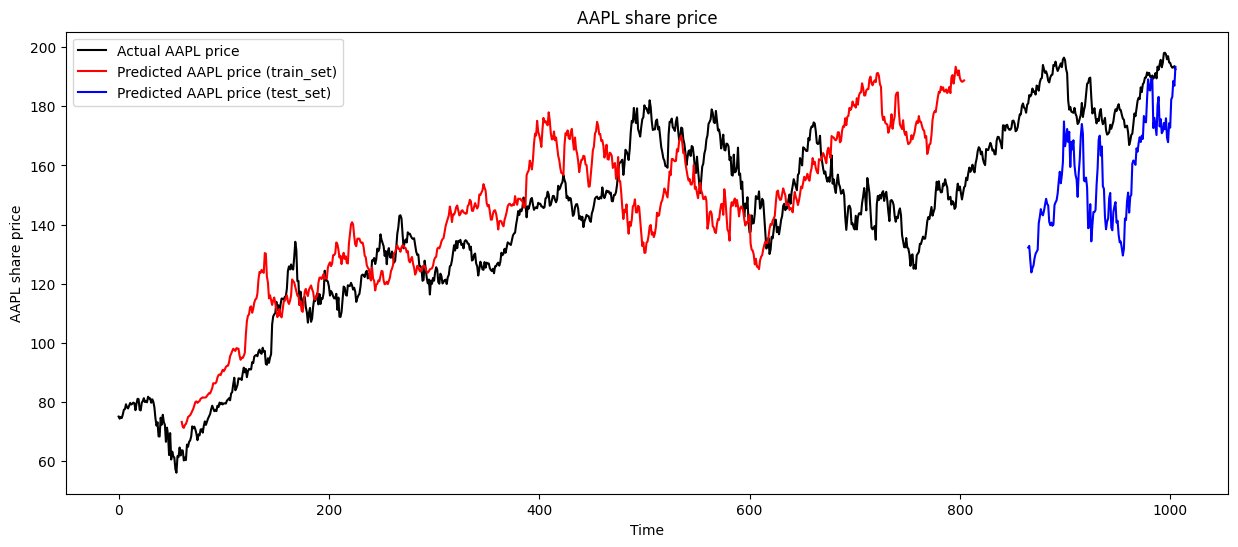

In [35]:
plot_predictions(new_df, train_predict, test_predict, company_name)

5/5 [==============================] - 0s 6ms/step
   Actual Close Prices  Predicted Close Prices
0           134.500000              132.221558
1           127.309998              132.800446
2           123.540001              127.733963
3           126.739998              123.819458
4           127.129997              125.227226


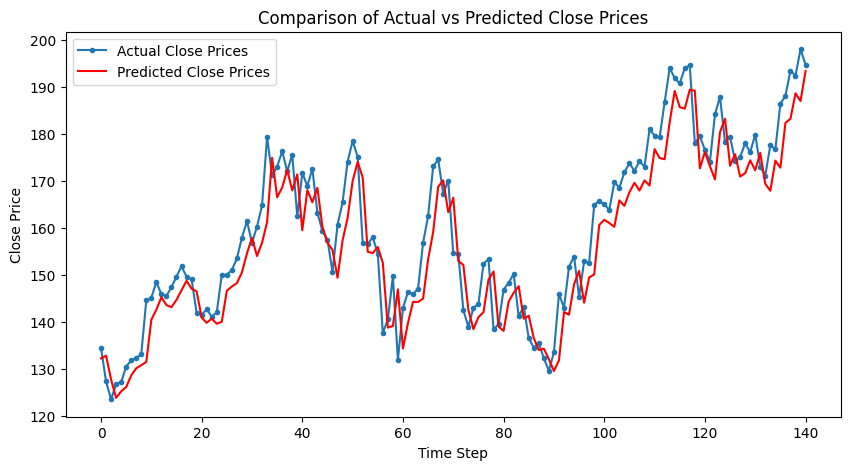

In [36]:
predictions = model.predict(x_test)

actual_values_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_values_inverse = scaler.inverse_transform(predictions)

comparison_df = pd.DataFrame({'Actual Close Prices': actual_values_inverse.flatten(), 'Predicted Close Prices': predicted_values_inverse.flatten()})
print(comparison_df.head())

plt.figure(figsize=(10, 5))
plt.plot(actual_values_inverse.flatten(), marker='.', label="Actual Close Prices")
plt.plot(predicted_values_inverse.flatten(), 'r', label="Predicted Close Prices")
plt.ylabel('Close Price')
plt.xlabel('Time Step')
plt.legend()
plt.title('Comparison of Actual vs Predicted Close Prices')
plt.show()
